### Performance comparison of SLS and LQR controllers with quadratic constraints on the state to avoid spheres

TODO: robust constraints missing for quadratic projections

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from copy import deepcopy
from time import time
import matplotlib.patches as mpatches

from isls import SLS
from isls.utils import get_double_integrator_AB
from isls.projections import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)
real_min = np.finfo(float).tiny

### Problem setup

In [2]:
x_dim = 2
u_dim = x_dim
T = 1.
horizon = 100
nb_deriv = 2
N = horizon
dt = T/horizon
print("dt:", dt)
d = x_dim*nb_deriv
A, B = get_double_integrator_AB(x_dim, nb_deriv=nb_deriv, dt=dt)

dt: 0.01


In [3]:
%%time
sls = SLS(d, u_dim, horizon)
sls.AB = [A,B]

Wall time: 4.01 ms


Define the task:

In [5]:
u_std=1e-4
x_std = 1e3
x_final_target = np.array([1., 1., 0., 0.])
viaQ_final = np.diag([x_std, x_std, x_std, x_std])

free_state = np.zeros(d)
viaQ_free = np.diag([0]*d)
zs = np.stack([free_state,  x_final_target])
Qs = np.stack([viaQ_free,  viaQ_final])

seq = np.zeros(N, dtype=np.int32)
seq[N-1] = 1
sls.set_quadratic_cost(zs, Qs, seq, u_std)

In [6]:
%%time
K_wo_const, k_wo_const = sls.solve(method="dp")
x0 = np.zeros(d)
x_opt, u_opt = sls.solve(x0, method="batch")

Wall time: 58 ms


MAX control:  6.059734752996613


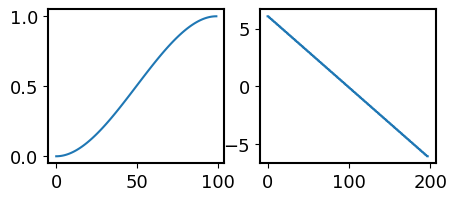

In [7]:
x0 = np.zeros(d)
fig,ax = plt.subplots(ncols=2, figsize=(5,2))
ax[1].plot(u_opt[:-1].flatten())
ax[0].plot(x_opt[:,0])

print("MAX control: ", np.max(u_opt))

## Obstacle avoidance spherical objects

We define a spherical obstacle at the position $x_0$ with a radius $r$. The constraint becomes
$r^2 \leq ||x-x_s||^2$, which can be tackled by quadric projections. The standard form becomes

$0.5r^2 - 0.5x_s^Tx_s\leq 0.5x^Tx - x_s^Tx $,

with $A=I$, $b=-x_0$, $l=0.5(r^2 - x_s^Tx_s)$ and $u=\inf$. \


In [8]:
# # Scenario 0:
radii = [0.1, 0.15]
xs = [np.array([0.5, 0.5])]
xs += [np.array([0.5, 0.2])]

# # # Scenario 1:
# radii = [0.1, 0.15]
# xs = [np.array([0.45, 0.5])]
# xs += [np.array([0.58, 0.45])]

# # #Scenario 2: (very bad situation)
# radii = [0.15, 0.15]
# xs = [np.array([0.45, 0.5]), np.array([0.55, 0.45])]

# # #Scenario 3:
# radii = [0.15, 0.25]
# xs = [np.array([0.8, 0.8]), np.array([0.2, 0.2])]

# #Scenario 4:
# radii = [0.3, 0.1]
# xs = [np.array([0.6, 0.5]), np.array([0.7, 0.43])]

# # #Scenario 5:
# radii = [0.15, 0.15]
# xs = [np.array([0.3, 0.6]), np.array([0.6, 0.3])]

radii_safe = np.array(radii)*1.1
nb_proj = len(radii)

lowers = [0.5*(radius**2) for radius in radii_safe]
upper = 1e2

As = [np.eye(x_dim)]*nb_proj
bs = [-xs[i]*0 for i in range(nb_proj)]
projections = [lambda x, lower=lower, i=i: project_quadratic(x-xs[i], lower, upper)+xs[i] for i,lower in enumerate(lowers)]


def project_state(x):
    x_ = x.reshape(-1,d).copy()
    x_[:,:x_dim] = project_set_convex(x_[:,:x_dim], As, bs, projections, max_iter=5, verbose=0, threshold=1e-2)
    x_[:,:x_dim] = project_set_convex_dykstra(x_[:,:x_dim], projections,  max_iter=50, verbose=0, tol=1e-5) # saves in the bad situations
    return x_.flatten()

ADMM residuals-> primal: 4.89e-02 dual: 1.80e-01
ADMM: Max iteration reached.
Constrained cost is 2.680e-01
Unconstrained cost is 2.473e-01
Wall time: 447 ms


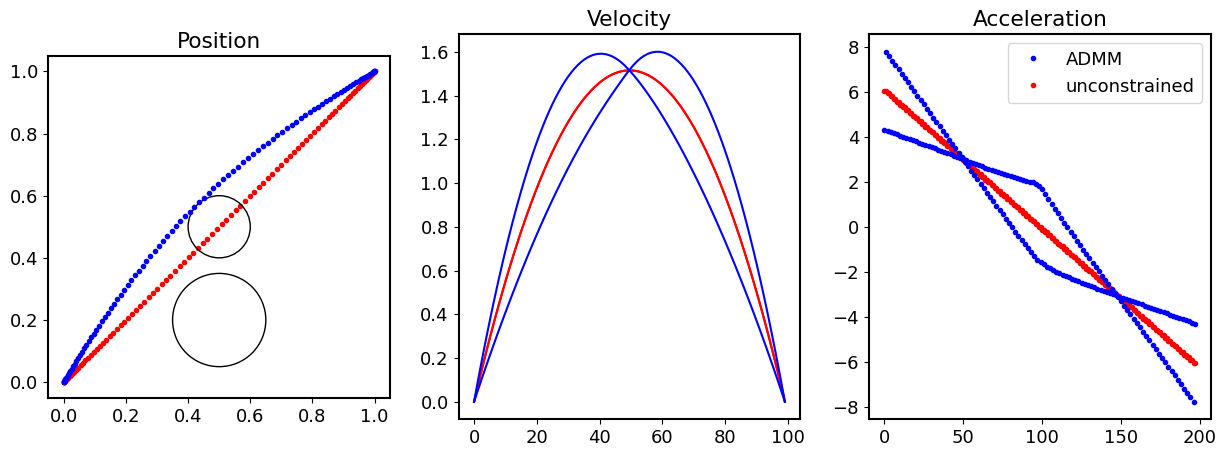

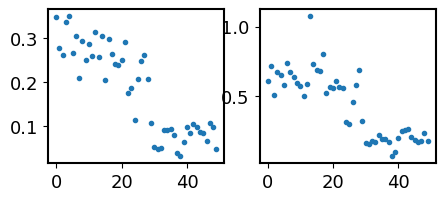

In [9]:
%%time
x0 = np.zeros(d)

rho_x = np.zeros((N, d, d))
rho_x[:, :x_dim, :x_dim] = np.eye(x_dim)*1e0

max_iter = 200

alpha= 1.


x_optimal,u_optimal, log = sls.ADMM_LQT_Batch(np.zeros(d), project_x=project_state, max_iter=max_iter, 
                                      rho_x=rho_x, alpha=alpha, tol=1e-3,  verbose=1, log=True)
fig,ax = plt.subplots(ncols=3, figsize=(15,5))
# x_optimal = sls.C[:,:d]@x0 + sls.D@u_optimal
u_optimal_ = u_optimal.reshape(N,-1)
x_optimal_ = x_optimal.reshape(N,-1)

ax[0].plot(x_optimal_[:,0], x_optimal_[:,1], ".b",label="ADMM")

# x_optimal2 = project_state(x_optimal).reshape(N,-1)
# ax[0].plot(x_optimal2[:,0], x_optimal2[:,1], ".g",label="proj_ADMM")

ax[0].plot(x_opt[:,0], x_opt[:,1], "r.", label="unconstrained", zorder=1)
ax[0].set_aspect("equal")

ax[1].plot(x_optimal_[:,x_dim:], "b")
ax[1].plot(x_opt[:,x_dim:], "r", zorder=1)

ax[2].plot(u_optimal_[:-1].flatten(), "b.", label="ADMM")
ax[2].plot(u_opt[:-1].flatten(), "r.", label="unconstrained", zorder=1)

titles = ["Position", "Velocity", "Acceleration"]
for i in range(3):
    ax[i].set_title(titles[i])

ax[-1].legend()
for i,center in enumerate(xs):
    circle = mpatches.Circle(center, radii[i],fill=False)
    ax[0].add_patch(circle)

print("Constrained cost is", "{:.3e}".format(sls.compute_cost(x_optimal, u_optimal)))
print("Unconstrained cost is", "{:.3e}".format(sls.compute_cost(x_opt, u_opt)))
fig,ax= plt.subplots(ncols=2, figsize=(5,2))
ax[0].plot(np.stack(log)[-50:,0], ".")
ax[1].plot(np.stack(log)[-50:,1], ".")

Constrained cost is 2.701e-01
Unconstrained cost is 2.473e-01
Wall time: 1.94 s


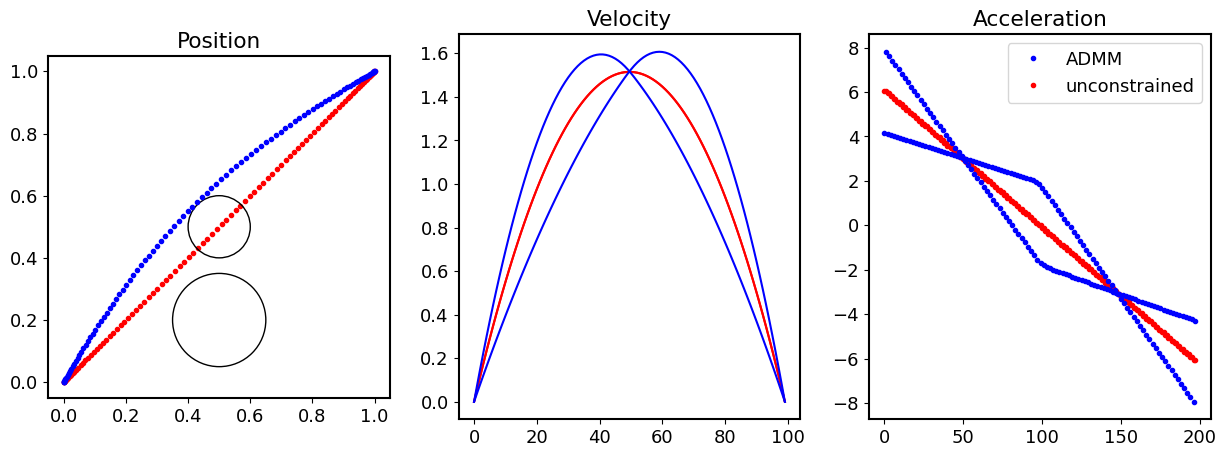

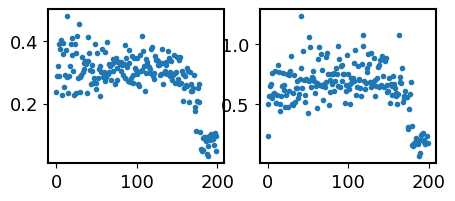

In [11]:
%%time
x_optimal, u_optimal,  K_optimal, k_optimal ,log_DP = sls.ADMM_LQT_DP(np.zeros(d), project_x=project_state,
                                                          max_iter=500,  rho_x=rho_x,  tol=1e-4, verbose=False, log=True)
fig,ax = plt.subplots(ncols=3, figsize=(15,5))
x_optimal = sls.Sw[:,:d]@x0 + sls.Su@u_optimal
u_optimal_ = u_optimal.reshape(N,-1)
x_optimal_ = x_optimal.reshape(N,-1)
# x_optimal_ = project_state(x_optimal).reshape(N,-1)
ax[0].plot(x_optimal_[:,0], x_optimal_[:,1], ".b",label="ADMM")
ax[0].plot(x_opt[:,0], x_opt[:,1], "r.", label="unconstrained", zorder=1)
ax[0].set_aspect("equal")

ax[1].plot(x_optimal_[:,x_dim:], "b")
ax[1].plot(x_opt[:,x_dim:], "r", zorder=1)

ax[2].plot(u_optimal_[:-1].flatten(), "b.", label="ADMM")
ax[2].plot(u_opt[:-1].flatten(), "r.", label="unconstrained", zorder=1)

titles = ["Position", "Velocity", "Acceleration"]
for i in range(3):
    ax[i].set_title(titles[i])

ax[-1].legend()
for i,center in enumerate(xs):
    circle = mpatches.Circle(center, radii[i],fill=False)
    ax[0].add_patch(circle)

print("Constrained cost is", "{:.3e}".format(sls.compute_cost(x_optimal, u_optimal)))
print("Unconstrained cost is", "{:.3e}".format(sls.compute_cost(x_opt, u_opt)))
fig,ax= plt.subplots(ncols=2, figsize=(5,2))
ax[0].plot(np.stack(log)[:,0], ".")
ax[1].plot(np.stack(log)[:,1], ".")

## Robust obstacle avoidance (todo)